## Reconocer imágenes con SVM(Support Vector Machines)

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Importar el dataset de caras

In [3]:
from sklearn.datasets import fetch_olivetti_faces

# obtener datos
faces = fetch_olivetti_faces()

print(faces.DESCR)

Modified Olivetti faces dataset.

The original database was available from

    http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

The version retrieved here comes in MATLAB format from the personal
web page of Sam Roweis:

    http://www.cs.nyu.edu/~roweis/

There are ten different images of each of 40 distinct subjects. For some
subjects, the images were taken at different times, varying the lighting,
facial expressions (open / closed eyes, smiling / not smiling) and facial
details (glasses / no glasses). All the images were taken against a dark
homogeneous background with the subjects in an upright, frontal position (with
tolerance for some side movement).

The original dataset consisted of 92 x 112, while the Roweis version
consists of 64x64 images.



faces.images tiene 400 imágenes de caras,cada una es una matriz de 64x64 px
faces.data tiene los mismos datos pero en filas de 4096 atributos en lugar de matrices

In [4]:
print(faces.keys())
print(faces.images.shape)
print(faces.data.shape)
print(faces.target.shape)


dict_keys(['data', 'images', 'target', 'DESCR'])
(400, 64, 64)
(400, 4096)
(400,)


Dibujar las 40 primeras imagenes

In [18]:
def print_faces(images, target, top_n):
    # establecer medidas para el grafico
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(top_n):
        # pintar las imágenes en una matriz de 20x20
        p = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone)
        
        # etiquetamos la imagen con el valor del target y el índice de la imagen
        p.text(0, 14, str(target[i]))
        p.text(0, 60, str(i))
    

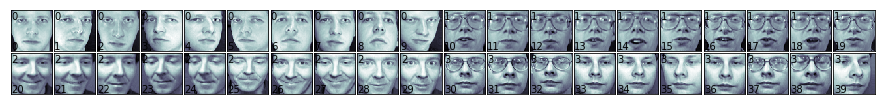

In [19]:
print_faces(faces.images, faces.target, 40)

Dibujamos todas las caras en una matriz de 20 x20 , para cada una, ponemos el valor del target y el índice de la imagen

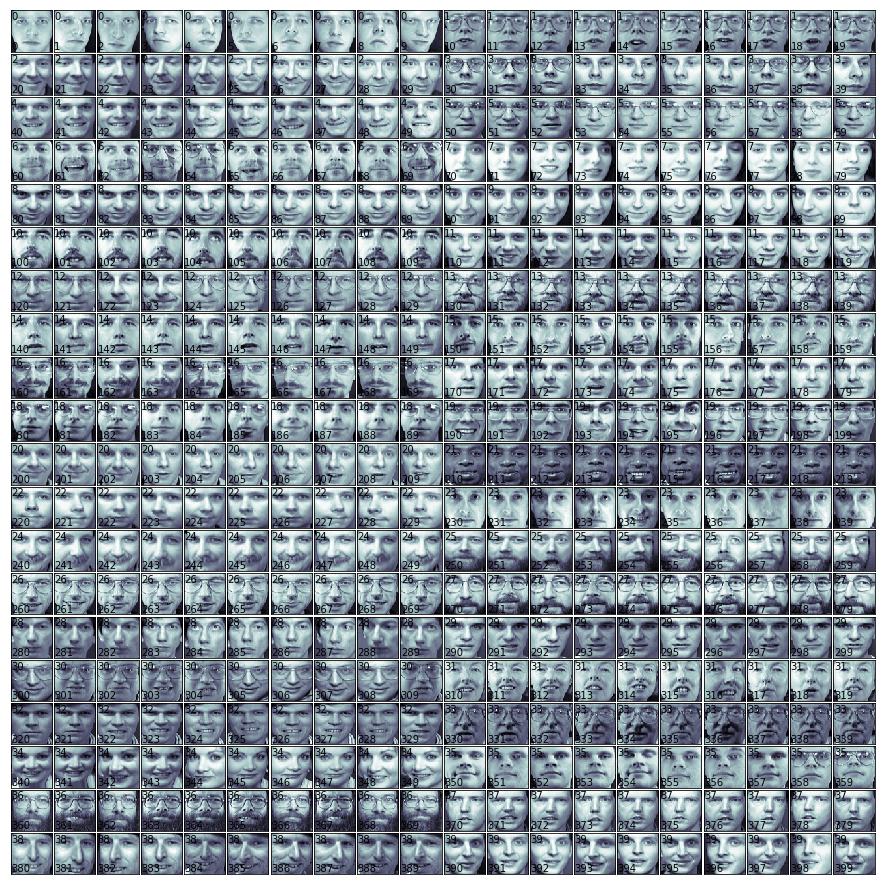

In [20]:
print_faces(faces.images, faces.target, 400)

Importamos el módulo sklearn.svm y usamos la clase SVC(Support Vector Classifier)

In [10]:
from sklearn.svm import SVC
svc_classifier = SVC(kernel='linear')
print(svc_classifier)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Obtenemos datos de entrenamiento y datos de test

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, test_size=0.3, random_state=0)

Realizar 5 veces la validación cruzada y obtenemos la media

In [22]:
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import sem

def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold croos validation iterator
    cv = KFold(K, shuffle=True, random_state=0)
    # obtener puntuacion
    scores = cross_val_score(clf, X, y, cv=cv)
    print(scores)
    print ("Puntuación media",np.mean(scores))

In [23]:
evaluate_cross_validation(svc_classifier, X_train, y_train, 5)

[ 0.92857143  0.96428571  0.92857143  0.94642857  0.91071429]
Puntuación media 0.935714285714


In [24]:
from sklearn import metrics

def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    
    clf.fit(X_train, y_train)
    
    print("Accuracy on training set:")
    print(clf.score(X_train, y_train))
    print("Accuracy on testing set:")
    print(clf.score(X_test, y_test))
    
    y_pred = clf.predict(X_test)
    
    print("Classification Report:")
    print(metrics.classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(metrics.confusion_matrix(y_test, y_pred))

In [25]:
train_and_evaluate(svc_classifier, X_train, X_test, y_train, y_test)

Accuracy on training set:
1.0
Accuracy on testing set:
0.958333333333
Classification Report:
             precision    recall  f1-score   support

          0       0.86      1.00      0.92         6
          1       1.00      1.00      1.00         4
          2       1.00      1.00      1.00         3
          3       0.33      1.00      0.50         1
          4       1.00      1.00      1.00         2
          5       1.00      1.00      1.00         5
          6       1.00      0.80      0.89         5
          7       1.00      0.67      0.80         3
          8       1.00      1.00      1.00         2
          9       1.00      1.00      1.00         2
         10       1.00      1.00      1.00         4
         11       1.00      1.00      1.00         1
         12       1.00      1.00      1.00         2
         13       1.00      1.00      1.00         3
         14       1.00      1.00      1.00         5
         15       1.00      0.60      0.75         5
     

/home/jmoc/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Clasificar imágenes de gente con gafas y sin gafas

In [26]:
# rangos de índices de imágenes de gente con gafas
glasses = [
	(10, 19), (30, 32), (37, 38), (50, 59), (63, 64),
	(69, 69), (120, 121), (124, 129), (130, 139), (160, 161),
	(164, 169), (180, 182), (185, 185), (189, 189), (190, 192),
	(194, 194), (196, 199), (260, 269), (270, 279), (300, 309),
	(330, 339), (358, 359), (360, 369)
]

Crear datos de entrenamiento y de test para el nuevo problema

In [27]:
def create_target(segments):
    # create a new y array of target size initialized with zeros
    y = np.zeros(faces.target.shape[0])
    # put 1 in the specified segments
    for (start, end) in segments:
        y[start:end + 1] = 1
    return y

In [28]:
target_glasses = create_target(glasses)

X_train, X_test, y_train, y_test = train_test_split(faces.data, target_glasses, test_size=0.3, random_state=0)

In [74]:
##Evaluamos nuestro modelo

In [29]:
svc_2 = SVC(kernel='linear')
evaluate_cross_validation(svc_2, X_train, y_train, 5)
train_and_evaluate(svc_2, X_train, X_test, y_train, y_test)

[ 1.          0.94642857  0.98214286  1.          0.94642857]
Puntuación media 0.975
Accuracy on training set:
1.0
Accuracy on testing set:
0.991666666667
Classification Report:
             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99        85
        1.0       0.97      1.00      0.99        35

avg / total       0.99      0.99      0.99       120

Confusion Matrix:
[[84  1]
 [ 0 35]]


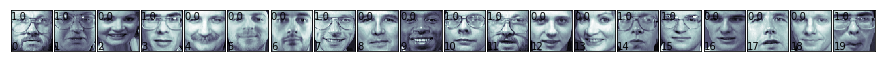

In [30]:
eval_faces = [np.reshape(a, (64, 64)) for a in X_test]
y_pred = svc_2.predict(X_test)
print_faces(eval_faces, y_pred, 20)